# Roq's (New) Simulator

Demonstrates how to simulate a C++ strategy using Python.

The tools demonstrated here are particularly useful for the following use-cases:

* Results are captured during simulation and can be easily extracted for further analysis.
* Permutations (different strategy parameters) can be generated from Python and multiple simulations can easily be scheduled.

This notebook will demonstrate enough concepts allowing you to implement your own work-flow and orchestrate your own simulations.

Roq comes with some basic strategies (used for this demonstration).
However, the main idea is that you can instantiate your own C++ strategy using the factory methods as demonstrated below.

The factory methods also allows you to control the configuration of the reporter and the matching engines used for exchange simulation.

## Pre-requisites

You can install Jupyter notebook using conda-forge!

```bash
conda install -y notebook
```

And launch it like this

```bash
jupyter notebook
```

It will then print the localhost URL you need to use to access it from a browser.

You probably also want to install some standard Python modules, e.g.

```bash
conda install -y pandas matplotlib
```

And Roq's Python binding

```bash
conda install -y --channel https://roq-trading.com/conda/unstable roq-python
```

## Design

![Desugb](static/images/simulator.png)

## Demonstration

We need some standard modules

In [1]:
import os
import datetime

import matplotlib as mpl

import pandas as pd

We also need Roq's Python binding (the `roq-python` package) providing the simulator and more

In [2]:
import roq

### Configuration

The settings structure is similar to what you would create in C++ when you parse command-line flags. The idea is that we can easily switch between different applications (simulator and live trading) without changing the configuration.

We only set the minimum required information

* `app.name` identifying this client
* `loop.timer_freq` configuring the frequency of the `Timer` event

In [3]:
settings = roq.client.Settings2(
    app={
        "name": "trader",
    },
    loop={
        "timer_freq": datetime.timedelta(milliseconds=100),
    },
    service={},
    common={},
)

These are the factory methods used by the simulator

* `create_strategy` (called just once) is used to create an instance of a C++ strategy
* `create_reporter` (called just once) is used to create an instance of a C++ reporter
* `create_matcher` is used to create matching engines used to simulate exchange markets

You will typically use the Roq provided reporter and matching engines with appropriate configuration.
However, you can also implement your own C++ versions and then instantiate them through these factory methods.

In [4]:
def create_strategy(dispatcher, order_cache, config):
    return roq.algo.strategy.create(
        type=roq.algo.strategy.Type.ARBITRAGE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
        parameters="max_age=10s;threshold=5;quantity_0=1;min_position_0=-5;max_position_0=5",
    )


def create_reporter():
    return roq.algo.reporter.Summary.create(
        market_data_source=roq.algo.MarketDataSource.TOP_OF_BOOK,
        sample_frequency=datetime.timedelta(seconds=60),
    )


def create_matcher(dispatcher, order_cache, config):
    return roq.algo.matcher.create(
        type=roq.algo.matcher.Type.SIMPLE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
    )


factory = roq.algo.Factory(
    create_strategy=create_strategy,
    create_reporter=create_reporter,
    create_matcher=create_matcher,
)

The strategy configuration is fundamentally a set of legs, each defined by

* The `source`, i.e. the index of the command-line argument (a `.roq` file for simulation, a `.sock` file for live trading)
* The `account` alias when the leg can be traded
* The `exchange` and `symbol` pair to identify the market

Optional fields, e.g. `time_in_fource` may define order management attributes.

In [5]:
config = roq.algo.strategy.Config(
    legs=[
        roq.algo.Leg(
            source=0,
            account="A1",
            exchange="deribit",
            symbol="BTC-PERPETUAL",
            time_in_force=roq.TimeInForce.GTC,
        ),
        roq.algo.Leg(
            source=1,
            account="A1",
            exchange="bybit",
            symbol="BTCUSD",
        ),
    ],
    strategy_id=123,
)

This a variable length list of "sources" (see the `source` index used for the strategy configuration above).

Each item is either a `.roq` file used by the simulator or a `.sock` file used by live trading.

This notebook demonstrates simulation and we're therefore using the `.roq` files.

In [6]:
parameters = [
    "{HOME}/var/lib/roq/data/deribit-public.roq".format(**os.environ),
    "{HOME}/var/lib/roq/data/bybit-public.roq".format(**os.environ),
]

### Simulation

This next step will run the simulator and return a reporter when done.

Note that the life-time of all objects are managed by the simulator using the factory methods.
This is done to avoid re-using objects which could potentially carry state from previous simulations.

In [7]:
# %%timeit -n 1 -r 1
reporter = roq.client.Simulator2.dispatch(
    settings=settings,
    factory=factory,
    config=config,
    parameters=parameters,
)

L0 simple.cpp:100] [0:deribit] connected
L0 simple.cpp:100] [1:bybit] connected
L0 simple.cpp:127] [0:deribit] ready
L0 simple.cpp:127] [1:bybit] ready
L0 simple.cpp:106] [0:deribit] disconnected
L0 simple.cpp:106] [1:bybit] disconnected


The reporter will have received all strategy events (input and output) during the simulation run.
Depending on the reporter type, raw or derived data may have been collected.

### Analysis

A small helper function to create a DataFrame when extracting a report from the reporter

In [8]:
def get_report(label):
    data, index = reporter.extract(label)
    return pd.DataFrame(data=data).set_index(index)

#### Report: SampleHistory

Now let's look at the collected samples

In [9]:
sample_history = get_report("sample_history")

Doing some trivial analysis...

In [10]:
leg_0 = sample_history.loc[(0,'deribit','BTC-PERPETUAL')]
leg_1 = sample_history.loc[(1,'bybit','BTCUSD')]

Let's first plot realized and unrealized profit per leg

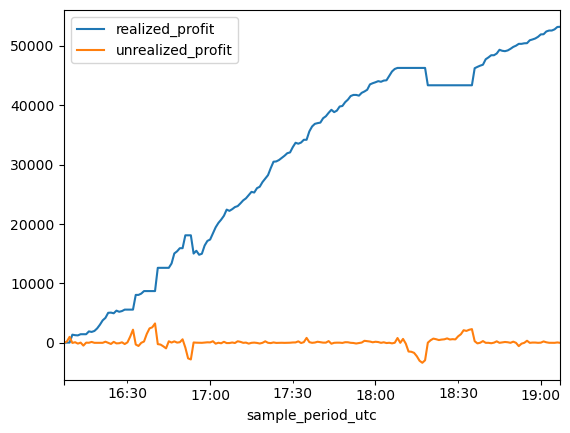

In [11]:
_ = leg_0[['realized_profit','unrealized_profit']].plot()

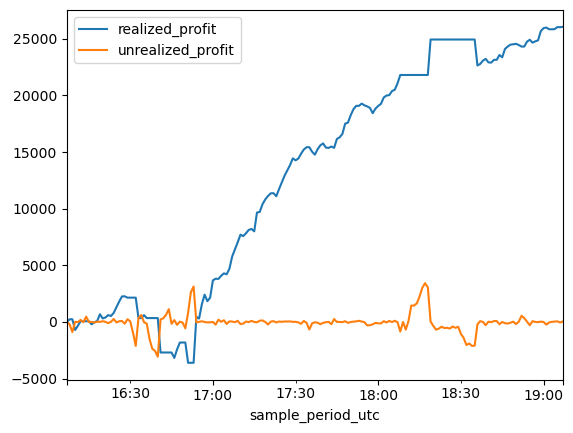

In [12]:
_ = leg_1[['realized_profit','unrealized_profit']].plot()

But we really only care about the combined profit

In [13]:
pnl_0 = leg_0.realized_profit + leg_0.unrealized_profit
pnl_1 = leg_1.realized_profit + leg_1.unrealized_profit
pnl = pnl_0 + pnl_1

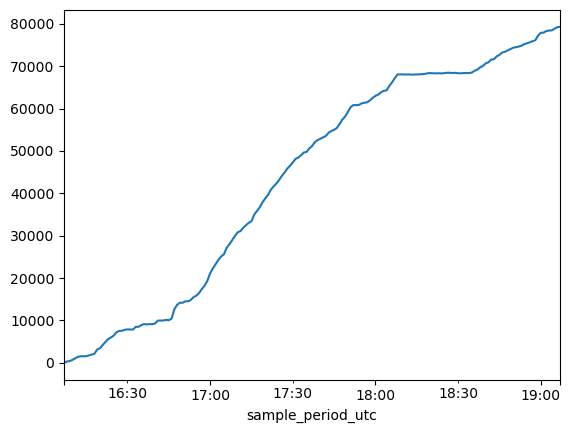

In [14]:
_ = pnl.plot()

... and of course, this is not a realistic simulation because we need to take into account the exchange fees which are directly proportional to the volume

The fee structure will normally depend on your specific tier and you must therefore use the volume and make your own adjustments to the profit shown in the previous step. You have enough information to achieve this:

In [15]:
vol_0 = leg_0.buy_volume + leg_0.sell_volume
vol_1 = leg_1.buy_volume + leg_1.sell_volume
vol = vol_0 + vol_1

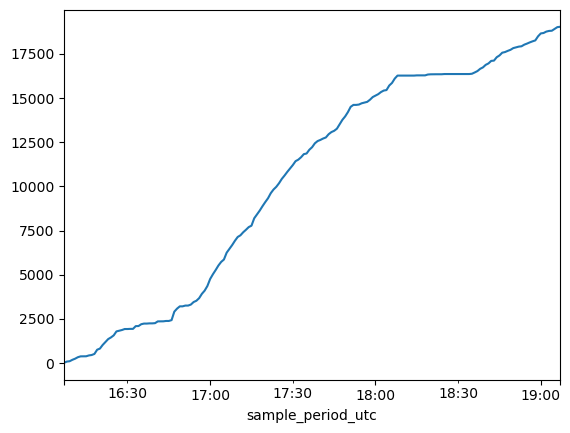

In [16]:
_ = vol.plot()

Let's look at the underlying prices.

Note that these are the best market prices from **last** updates for each sample period.

In [17]:
mid_0 = (leg_0.best_bid_price + leg_0.best_ask_price) / 2
mid_1 = (leg_1.best_bid_price + leg_1.best_ask_price) / 2

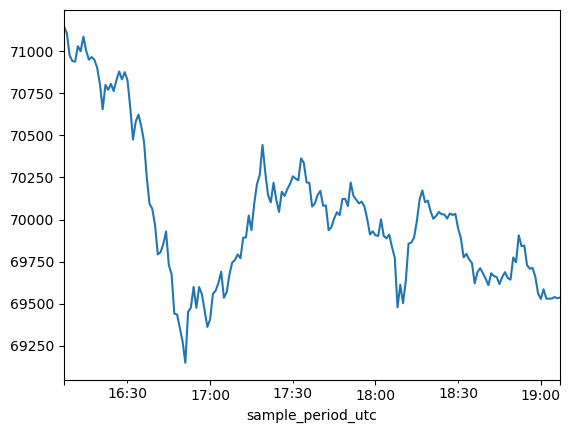

In [18]:
_ = mid_0.plot()

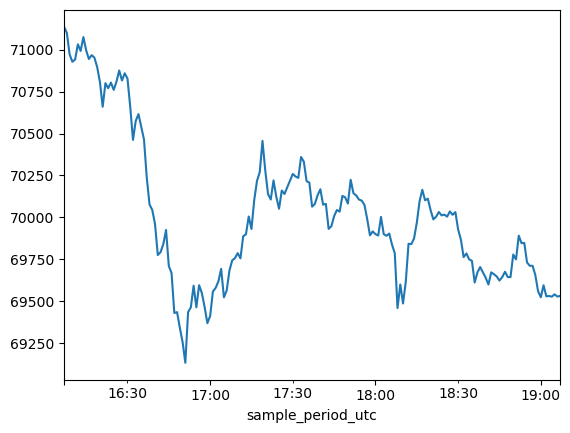

In [19]:
_ = mid_1.plot()

The strategy uses the spread for positioning

In [20]:
spread = mid_0 - mid_1

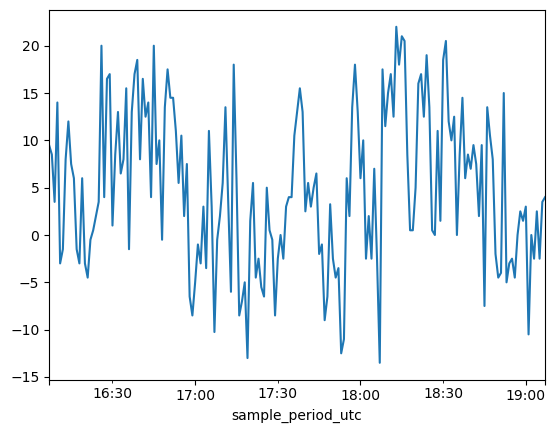

In [21]:
_ = spread.plot()

This strategy uses the first leg (index 0) as the basis for scaling other legs.

There are some complications making it a little difficult to demonstrate positions

* The strategy works with a target positions.
* There is a simulated latency such that each leg takes some time to fill.
* A limit order may be aggressive or passive depending on the price chosen by the strategy and the latency to the market.
* The strategy may change the aggressiveness of a limit order depending on what happens with the orders from other legs.

In [22]:
pos_0 = leg_0.position

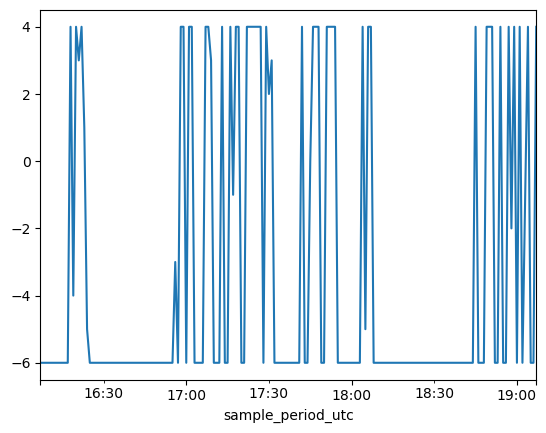

In [23]:
_ = pos_0.plot()

#### Report: OrderUpdate

In [24]:
order_update = get_report("order_update")
order_update

side  \
source exchange symbol        account order_id sending_time_utc                
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605  SELL   
                                      1003     2024-11-01 16:07:27.733  SELL   
                                      1005     2024-11-01 16:07:27.751  SELL   
                                      1007     2024-11-01 16:07:27.787  SELL   
                                      1009     2024-11-01 16:07:27.809  SELL   
...                                                                      ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050  SELL   
                                      20034    2024-11-01 19:07:03.090  SELL   
                                      20036    2024-11-01 19:07:03.110  SELL   
                                      20038    2024-11-01 19:07:03.110  SELL   
                                      20040    2024-11-01 19:07:03.130  SELL   

                                                                               create_time_utc  \
source exchange symbol        account order_id sending_time_utc                                  
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605 2024-11-01 16:07:26.605   
                                      1003     2024-11-01 16:07:27.733 2024-11-01 16:07:27.733   
                                      1005     2024-11-01 16:07:27.751 2024-11-01 16:07:27.751   
                                      1007     2024-11-01 16:07:27.787 2024-11-01 16:07:27.787   
                                      1009     2024-11-01 16:07:27.809 2024-11-01 16:07:27.809   
...                                                                                        ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050 2024-11-01 19:07:03.050   
                                      20034    2024-11-01 19:07:03.090 2024-11-01 19:07:03.090   
                                      20036    2024-11-01 19:07:03.110 2024-11-01 19:07:03.110   
                                      20038    2024-11-01 19:07:03.110 2024-11-01 19:07:03.110   
                                      20040    2024-11-01 19:07:03.130 2024-11-01 19:07:03.130   

                                                                               update_time_utc  \
source exchange symbol        account order_id sending_time_utc                                  
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605 2024-11-01 16:07:26.605   
                                      1003     2024-11-01 16:07:27.733 2024-11-01 16:07:27.733   
                                      1005     2024-11-01 16:07:27.751 2024-11-01 16:07:27.751   
                                      1007     2024-11-01 16:07:27.787 2024-11-01 16:07:27.787   
                                      1009     2024-11-01 16:07:27.809 2024-11-01 16:07:27.809   
...                                                                                        ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050 2024-11-01 19:07:03.050   
                                      20034    2024-11-01 19:07:03.090 2024-11-01 19:07:03.090   
                                      20036    2024-11-01 19:07:03.110 2024-11-01 19:07:03.110   
                                      20038    2024-11-01 19:07:03.110 2024-11-01 19:07:03.110   
                                      20040    2024-11-01 19:07:03.130 2024-11-01 19:07:03.130   

                                                                       order_status  \
source exchange symbol        account order_id sending_time_utc                       
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605    COMPLETED   
                                      1003     2024-11-01 16:07:27.733    COMPLETED   
                                      1005     2024-11-01 16:07:27.751    COMPLETED   
                                      1007    

#### Report: TradeUpdate

In [25]:
trade_update = get_report("trade_update")
trade_update

side  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id         
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605 trd-1              SELL   
                                      1003     2024-11-01 16:07:27.733 trd-3              SELL   
                                      1005     2024-11-01 16:07:27.751 trd-5              SELL   
                                      1007     2024-11-01 16:07:27.787 trd-7              SELL   
                                      1009     2024-11-01 16:07:27.809 trd-9              SELL   
...                                                                                        ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050 trd-19032          SELL   
                                      20034    2024-11-01 19:07:03.090 trd-19034          SELL   
                                      20036    2024-11-01 19:07:03.110 trd-19036          SELL   
                                      20038    2024-11-01 19:07:03.110 trd-19038          SELL   
                                      20040    2024-11-01 19:07:03.130 trd-19040          SELL   

                                                                                                 create_time_utc  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id                           
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605 trd-1             2024-11-01 16:07:26.605   
                                      1003     2024-11-01 16:07:27.733 trd-3             2024-11-01 16:07:27.733   
                                      1005     2024-11-01 16:07:27.751 trd-5             2024-11-01 16:07:27.751   
                                      1007     2024-11-01 16:07:27.787 trd-7             2024-11-01 16:07:27.787   
                                      1009     2024-11-01 16:07:27.809 trd-9             2024-11-01 16:07:27.809   
...                                                                                                          ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050 trd-19032         2024-11-01 19:07:03.050   
                                      20034    2024-11-01 19:07:03.090 trd-19034         2024-11-01 19:07:03.090   
                                      20036    2024-11-01 19:07:03.110 trd-19036         2024-11-01 19:07:03.110   
                                      20038    2024-11-01 19:07:03.110 trd-19038         2024-11-01 19:07:03.110   
                                      20040    2024-11-01 19:07:03.130 trd-19040         2024-11-01 19:07:03.130   

                                                                                                 update_time_utc  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id                           
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:26.605 trd-1             2024-11-01 16:07:26.605   
                                      1003     2024-11-01 16:07:27.733 trd-3             2024-11-01 16:07:27.733   
                                      1005     2024-11-01 16:07:27.751 trd-5             2024-11-01 16:07:27.751   
                                      1007     2024-11-01 16:07:27.787 trd-7             2024-11-01 16:07:27.787   
                                      1009     2024-11-01 16:07:27.809 trd-9             2024-11-01 16:07:27.809   
...                                                                                                          ...   
1      bybit    BTCUSD        A1      20032    2024-11-01 19:07:03.050 trd-19032         2024-11-01 19:07:03.050   
                                      20034    2024-11-01 19:07:03.090 trd-19034         2024-11-01 19:07:03.090   
                                      20036    2024-11-01 19:07:03.110 trd-19036         2024-11-01 19:07:03.110   
                              

## Summary

The point of this notebook was to demonstrate how to run a strategy through the simulator and use the reporter as the basis for further data analysis.

## Disclaimer

BSD 3-Clause License                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                   
Copyright (c) 2017-2024, Hans Erik Thrane                                                                                                                          
All rights reserved.                                                                                                                                            
                                                                                                                                                                
Redistribution and use in source and binary forms, with or without                                                                                              
modification, are permitted provided that the following conditions are met:                                                                                     
                                                                                                                                                                
* Redistributions of source code must retain the above copyright notice, this                                                                                   
  list of conditions and the following disclaimer.                                                                                                              
                                                                                                                                                                
* Redistributions in binary form must reproduce the above copyright notice,                                                                                     
  this list of conditions and the following disclaimer in the documentation                                                                                     
  and/or other materials provided with the distribution.                                                                                                           
                                                                                                                                                                   
* Neither the name of the copyright holder nor the names of its                                                                                                    
  contributors may be used to endorse or promote products derived from                                                                                             
  this software without specific prior written permission.                                                                                                         
                                                                                                                                                                   
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"                                                                                        
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE                                                                                          
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE                                                                                     
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE                                                                                       
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL                                                                                         
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR                                                                                         
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER                                                                                         
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,                                                                                      
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE                                                                                      
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 